In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

In [2]:
def interpolate_cycle(cycle_data, num_points=100):
    """
    Interpolates the cycle data to a fixed number of points using  interpolation.
    
    Args:
    - cycle_data: The joint angle data for one cycle.
    - num_points: Number of points to interpolate to (default is 100).
    
    Returns:
    - Interpolated joint angle data at fixed points.
    """
    x_old = np.arange(len(cycle_data))  # Original indices
    f = interp1d(x_old, cycle_data, kind='quadratic', fill_value="extrapolate")
    x_new = np.linspace(0, len(x_old)-1, num_points) 
    y_new = f(x_new)  # Interpolated joint angles
    return x_new, y_new

In [3]:
# Plotting function to compare original and interpolated joint angles
def plot_comparison(cycles, joints=['Hip', 'Knee', 'Ankle'], num_points=100):
    # Create subplots with 3 rows and 2 columns
    _, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))
    
    # Plot non-interpolated (left column) and interpolated (right column)
    for idx, joint in enumerate(joints):
        # Non-interpolated plot (left)
        for i, (cycle_name, cycle_slice) in enumerate(cycles.items(), start=1):
            axes[idx, 0].plot(cycle_slice[joint].values, label=f"Cycle {i}")
        axes[idx, 0].set_xlabel('Frames')
        axes[idx, 0].set_ylabel(f'{joint} Angle')
        axes[idx, 0].grid(True, linestyle='--', alpha=0.7)
        axes[idx, 0].set_title(f'Non-interpolated {joint} Angle')
        
        # Interpolated plot (right)
        for i, (cycle_name, cycle_slice) in enumerate(cycles.items(), start=1):
            x_old = np.arange(len(cycle_slice[joint]))
            x_new, y_new = interpolate_cycle(cycle_slice[joint], num_points)
            axes[idx, 1].plot(x_new / max(x_new), y_new, label=f"Cycle {i}")  # Normalize x-axis to [0, 1]
        axes[idx, 1].set_xlabel('Normalized Frames')
        axes[idx, 1].set_ylabel(f'{joint} Angle')
        axes[idx, 1].grid(True, linestyle='--', alpha=0.7)
        axes[idx, 1].set_title(f'Interpolated {joint} Angle')
        
        # Add legends
        axes[idx, 0].legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
        axes[idx, 1].legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
    
    plt.tight_layout()
    plt.show()

In [4]:
def plot_mean_comparison(cycles, joints=['Hip', 'Knee', 'Ankle']):
    plt.style.use('bmh')
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))
    fig.suptitle('Gait Cycle Analysis - {sub}', fontsize=16, y=1.02)
    
    # Define colors
    cycle_color = '#E6E6E6'      # Light gray for individual cycles
    mean_color = '#FF4B4B'       # Bright red for mean
    std_color = '#FF4B4B'        # Color for standard deviation band
    
    for idx, joint in enumerate(joints):
        # Non-normalized plots (left)
        for cycle_name, cycle_slice in cycles.items():
            axes[idx, 0].plot(cycle_slice[joint].values, 
                            color=cycle_color, 
                            alpha=0.3, 
                            linewidth=1,
                            zorder=1)
            
        # Calculate mean and std for non-normalized
        max_length = max(len(cycle_slice[joint]) for cycle_slice in cycles.values())
        aligned_data = np.zeros((len(cycles), max_length))
        for i, cycle_slice in enumerate(cycles.values()):
            aligned_data[i, :len(cycle_slice[joint])] = cycle_slice[joint].values
            
        mean_curve = np.nanmean(aligned_data, axis=0)
        std_curve = np.nanstd(aligned_data, axis=0)
        
        # Plot mean and std bands
        x_range = np.arange(len(mean_curve))
        axes[idx, 0].fill_between(x_range, 
                                mean_curve - std_curve, 
                                mean_curve + std_curve, 
                                color=std_color, 
                                alpha=0.2,
                                label='±1 SD',
                                zorder=2)
        axes[idx, 0].plot(mean_curve, 
                         color=mean_color, 
                         linewidth=3, 
                         label='Mean',
                         zorder=3)
        
        # Interpolated plots (right)
        interpolated_data = []
        for cycle_name, cycle_slice in cycles.items():
            _, y_interpolated = interpolate_cycle(cycle_slice[joint].values)
            x_interpolated = np.linspace(0, 1, len(y_interpolated))
            axes[idx, 1].plot(x_interpolated, y_interpolated, color=cycle_color, alpha=0.3, linewidth=1, zorder=1)
            interpolated_data.append(pd.DataFrame({
                'x': x_interpolated,
                'y': y_interpolated
            }))
        
        # Calculate and plot interpolated mean
        combined_df = pd.concat(interpolated_data)
        mean_curve = combined_df.groupby('x')['y'].mean()
        
        # Calculate mean and std for normalized data
        combined_df = pd.concat(interpolated_data)
        grouped = combined_df.groupby('x')
        mean_curve = grouped['y'].mean()
        std_curve = grouped['y'].std()
        
        # Plot normalized mean and std bands
        axes[idx, 1].fill_between(mean_curve.index, 
                                mean_curve - std_curve, 
                                mean_curve + std_curve, 
                                color=std_color, 
                                alpha=0.2,
                                label='±1 SD',
                                zorder=2)
        axes[idx, 1].plot(mean_curve.index, mean_curve.values, 
                         color=mean_color, 
                         linewidth=3, 
                         label='Mean',
                         zorder=2)
        
        # Customize each subplot
        for col in range(2):
            axes[idx, col].grid(True, linestyle='--', alpha=0.3)
            axes[idx, col].set_ylabel(f'{joint} Angle (degrees)', fontsize=12)
            axes[idx, col].legend(loc='upper right', 
                                frameon=True, 
                                facecolor='white', 
                                edgecolor='none',
                                fontsize=10)
            axes[idx, col].spines['top'].set_visible(False)
            axes[idx, col].spines['right'].set_visible(False)
            
        axes[idx, 0].set_xlabel('Frames', fontsize=12)
        axes[idx, 0].set_title(f'Non-normalized {joint} Angle', fontsize=14, pad=15)
        axes[idx, 1].set_xlabel('Gait Cycle (%)', fontsize=12)
        axes[idx, 1].set_title(f'Normalized {joint} Angle', fontsize=14, pad=15)
        
        # Set x-axis for normalized plots to show percentages
        axes[idx, 1].set_xlim(0, 1)
        axes[idx, 1].set_xticks(np.arange(0, 1.1, 0.2))
        axes[idx, 1].set_xticklabels([f'{int(x*100)}%' for x in np.arange(0, 1.1, 0.2)])
    
    plt.tight_layout()
    plt.show()

In [5]:
def analyze_gait_phases(cycles, joints=['Hip', 'Knee', 'Ankle']):
    """
    Analyze standardized phases of the gait cycle for each joint
    
    Parameters:
    cycles (dict): Dictionary containing gait cycle data for each joint
    joints (list): List of joints to analyze (default: ['Hip', 'Knee', 'Ankle'])
    
    Returns:
    dict: Dictionary containing phase analysis results for each joint
    """
    results = {}
    
    # Define standardized gait phases
    phases = [
        ("Initial Contact (0-2%)", 0, 2, "blue"),
        ("Loading Response (2-12%)", 2, 12, "cyan"),
        ("Midstance (12-30%)", 12, 30, "green"),
        ("Terminal Stance (30-50%)", 30, 50, "yellow"),
        ("Pre-Swing (50-60%)", 50, 60, "orange"),
        ("Initial Swing (60-73%)", 60, 73, "red"),
        ("Midswing (73-87%)", 73, 87, "purple"),
        ("Terminal Swing (87-100%)", 87, 100, "pink")
    ]
    
    for joint in joints:
        phase_data = []
        
        for cycle_name, cycle_slice in cycles.items():
            # Convert frame indices to percentages
            total_frames = len(cycle_slice)
            normalized_data = pd.DataFrame({
                'angle': cycle_slice[joint].values,
                'percent': np.linspace(0, 100, total_frames)
            })
            
            cycle_phases = {}
            
            # Analyze each standardized phase
            for phase_name, start_percent, end_percent, color in phases:
                phase_data_slice = normalized_data[
                    (normalized_data['percent'] >= start_percent) &
                    (normalized_data['percent'] <= end_percent)
                ]
                
                # Calculate phase metrics
                cycle_phases[f"{phase_name}_mean"] = phase_data_slice['angle'].mean()
                cycle_phases[f"{phase_name}_min"] = phase_data_slice['angle'].min()
                cycle_phases[f"{phase_name}_max"] = phase_data_slice['angle'].max()
                cycle_phases[f"{phase_name}_ROM"] = (
                    phase_data_slice['angle'].max() - 
                    phase_data_slice['angle'].min()
                )
                
                # Store color for visualization purposes
                cycle_phases[f"{phase_name}_color"] = color
            
            phase_data.append(cycle_phases)
        
        # Convert to DataFrame
        df_phases = pd.DataFrame(phase_data)
        
        # Calculate statistics for each phase
        # Exclude color columns from statistical calculations
        stat_columns = [col for col in df_phases.columns if not col.endswith('_color')]
        phase_stats = pd.DataFrame({
            'Mean': df_phases[stat_columns].mean(),
            'SD': df_phases[stat_columns].std(),
            'Min': df_phases[stat_columns].min(),
            'Max': df_phases[stat_columns].max()
        })
        
        results[joint] = {
            'individual_phases': df_phases,
            'phase_stats': phase_stats,
            'phases': phases  # Store phase definitions for reference
        }
    
    return results

In [6]:
def create_comprehensive_gait_visualization(cycles, phase_results):
    """
    Create a comprehensive visualization of gait analysis results
    
    Parameters:
    cycles (dict): Dictionary containing gait cycle data
    phase_results (dict): Dictionary containing phase analysis results
    """
    plt.style.use('bmh')
    
    # Create figure with a 3x2 grid
    fig = plt.figure(figsize=(20, 25))
    fig.suptitle(f'Comprehensive Gait Analysis - {subject_ID}', fontsize=16, y=0.95)
    
    # Define colors for joints
    colors = {'Hip': '#FF4B4B', 'Knee': '#4B4BFF', 'Ankle': '#4BFF4B'}
    
    # Define standardized gait phases
    phases = [
        ("Initial Contact (0-2%)", 0, 2, "blue"),
        ("Loading Response (2-12%)", 2, 12, "cyan"),
        ("Midstance (12-30%)", 12, 30, "green"),
        ("Terminal Stance (30-50%)", 30, 50, "yellow"),
        ("Pre-Swing (50-60%)", 50, 60, "orange"),
        ("Initial Swing (60-73%)", 60, 73, "red"),
        ("Midswing (73-87%)", 73, 87, "purple"),
        ("Terminal Swing (87-100%)", 87, 100, "pink")
    ]
    
    # 1. Joint Angles Over Gait Cycle (Normalized) - Top Row
    ax1 = plt.subplot(3, 2, (1, 2))
    
    # Add color fills for gait phases
    for phase_name, start, end, color in phases:
        ax1.axvspan(start, end, color=color, alpha=0.2, label=f"{phase_name}")
    
    for joint in ['Hip', 'Knee', 'Ankle']:
        # Calculate mean curve
        interpolated_data = []
        for cycle_name, cycle_slice in cycles.items():
            _, y_interpolated = interpolate_cycle(cycle_slice[joint].values)
            x_interpolated = np.linspace(0, 100, len(y_interpolated))
            interpolated_data.append(pd.DataFrame({
                'x': x_interpolated,
                'y': y_interpolated
            }))
        
        combined_df = pd.concat(interpolated_data)
        mean_curve = combined_df.groupby('x')['y'].mean()
        std_curve = combined_df.groupby('x')['y'].std()
        
        # Plot mean and std
        ax1.plot(mean_curve.index, mean_curve.values, 
                label=joint, color=colors[joint], linewidth=2)
        # ax1.fill_between(mean_curve.index, 
        #                 mean_curve - std_curve, 
        #                 mean_curve + std_curve, 
        #                 color=colors[joint], alpha=0.2)
        ax1.fill_between(mean_curve.index, 
                                mean_curve - std_curve, 
                                mean_curve + std_curve, 
                                color=colors[joint], 
                                alpha=0.2,
                                label='±1 SD',
                                zorder=2)
    
    ax1.set_xlabel('Gait Cycle (%)', fontsize=12)
    ax1.set_ylabel('Joint Angle (degrees)', fontsize=12)
    ax1.set_title('Joint Angles Throughout Gait Cycle', fontsize=14, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Create two separate legends for joints and phases
    joint_handles = [plt.Line2D([0], [0], color=color, lw=2) for color in colors.values()]
    phase_handles = [plt.Rectangle((0,0), 1, 1, fc=phase[3], alpha=0.2) for phase in phases]
    
    ax1.legend(joint_handles + phase_handles, 
              list(colors.keys()) + [phase[0] for phase in phases],
              loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
    
    # 2. Range of Motion Boxplot
    ax2 = plt.subplot(3, 2, 5)
    rom_data = []
    labels = []
    for joint in ['Hip', 'Knee', 'Ankle']:
        for cycle_slice in cycles.values():
            rom = cycle_slice[joint].max() - cycle_slice[joint].min()
            rom_data.append(rom)
            labels.append(joint)
    
    sns.boxplot(x=labels, y=rom_data, hue=labels, palette=colors, ax=ax2, dodge=False,legend=False)
    ax2.set_title('Range of Motion Distribution', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Degrees', fontsize=12)
    ax2.set_xlabel('Joint', fontsize=12)
    
    # 3. Phase Analysis - Middle Right
    ax3 = plt.subplot(3, 2, (3,4))
    
    # Extract phase names for x-axis labels
    phase_names = [phase[0] for phase in phases]
    x_positions = np.arange(len(phases))
    width = 0.25
    
    # Plot bars for each joint
    for i, joint in enumerate(['Hip', 'Knee', 'Ankle']):
        means = []
        sds = []
        for phase_name, _, _, _ in phases:
            phase_key = f"{phase_name}_mean"
            if phase_key in phase_results[joint]['phase_stats'].index:
                means.append(phase_results[joint]['phase_stats'].loc[phase_key, 'Mean'])
                sds.append(phase_results[joint]['phase_stats'].loc[phase_key, 'SD'])
            else:
                means.append(0)
                sds.append(0)
        
        ax3.bar(x_positions + i * width, means, width,
                label=joint, color=colors[joint],
                yerr=sds, capsize=5)
    
    # Add phase background colors
    for i, (_, _, _, color) in enumerate(phases):
        ax3.axvspan(i - 0.4, i + 0.8, alpha=0.1, color=color)
    
    ax3.set_xticks(x_positions + width)
    ax3.set_xticklabels(phase_names, rotation=45, ha='right', fontsize=10)
    ax3.set_title('Phase Analysis of Joint Angles', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Joint Angle (degrees)', fontsize=12)
    ax3.legend(loc='upper left', fontsize=10)
    ax3.grid(alpha=0.5, linestyle='--')
    
    # 5. Temporal Parameters - Bottom Right
    ax5 = plt.subplot(3, 2, 6)
    cycle_durations = [len(cycle_slice) / 30 for cycle_slice in cycles.values()]  # Assuming 30 fps
    
    sns.histplot(cycle_durations, kde=True, ax=ax5)
    mean_duration = np.mean(cycle_durations)
    ax5.axvline(mean_duration, color='red', linestyle='--', 
                label=f'Mean: {mean_duration:.2f}s')
    ax5.set_title('Gait Cycle Duration Distribution', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Duration (seconds)', fontsize=12)
    ax5.set_ylabel('Count', fontsize=12)
    ax5.legend(fontsize=10)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [7]:
subjects = {
    'P001R':[32,85,139,192,243,295,349,400,452,506,558,610,660,710,761,812,863],
    'P002L': [12, 52, 91, 130, 169, 209, 250, 289, 329, 369, 409],
    'P003L' : [40,86,131,178,223,270,316,362,408,458,505,552]
}

In [8]:
subject_ID = 'P001R'

In [9]:
df = pd.read_csv(rf"E:\Gait Analysis NMH\CSV_Full\{subject_ID}.csv")

In [10]:
cycles = {f"cycle{i}": df.iloc[subjects[subject_ID][i-1]-1:subjects[subject_ID][i]-1] for i in range(1, len(subjects[subject_ID]))}

In [11]:
cycle_lengths = [len(cycle_slice) for cycle_slice in cycles.values()]
mean_cycle_length = np.mean(cycle_lengths)
max_cycle_length = np.max(cycle_lengths)
min_cycle_length = np.min(cycle_lengths)
print(f"Mean length of cycle: {mean_cycle_length} frames")
print(f"Max length of cycle: {max_cycle_length} frames")
print(f"Min length of cycle: {min_cycle_length} frames")
print(f"Average time to complete single cycle: {np.round(mean_cycle_length / 30,2)} secs")

Mean length of cycle: 51.9375 frames
Max length of cycle: 54 frames
Min length of cycle: 50 frames
Average time to complete single cycle: 1.73 secs


In [12]:
phase_results = analyze_gait_phases(cycles)

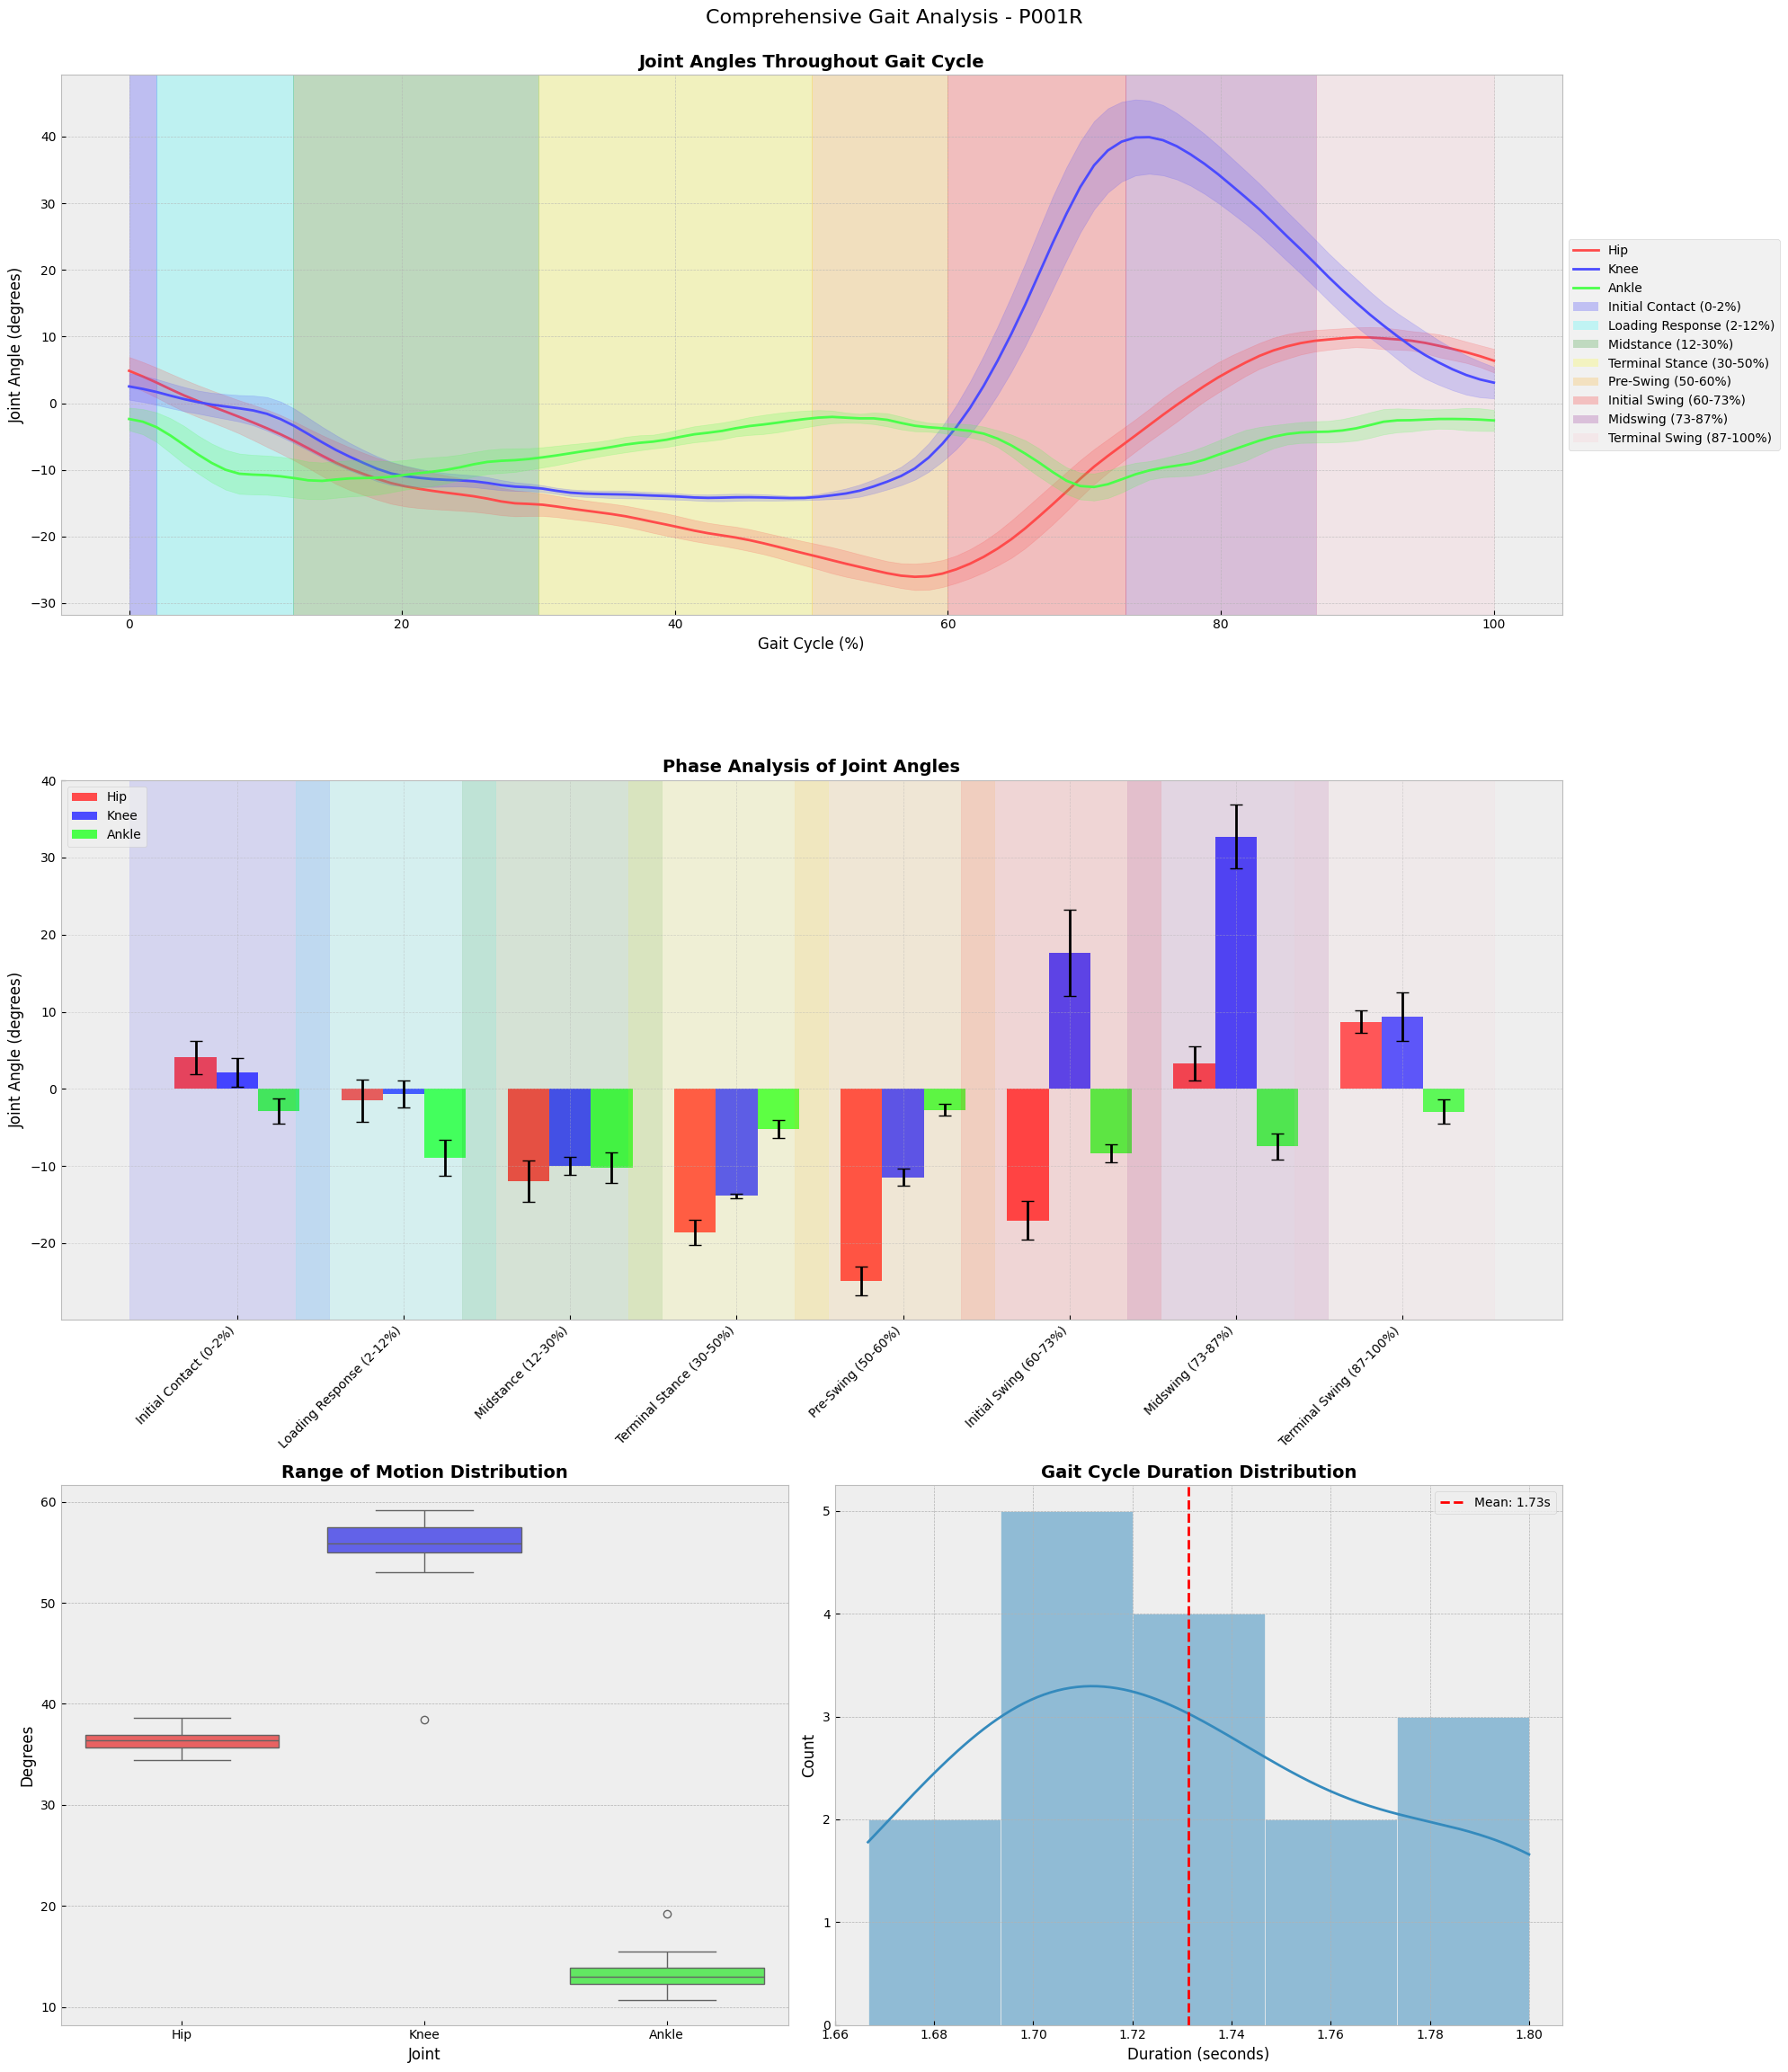

In [13]:
create_comprehensive_gait_visualization(cycles, phase_results)